# Import required packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pydicom as dicom
import csv
from tensorflow.keras.applications.mobilenet import preprocess_input
import timeit
import seaborn as sns

In [2]:
#testing GPU availability:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# setting up the directory to path:
path=r'D:\DS AI ML\Capstone Project CV'
os.chdir(path)

In [4]:
#checking folders into the current directory:
os.listdir()
folders=[]
for file in os.listdir():
    temp=file.split('.')
    if len(temp)==1:
        folders.append(file)

In [5]:
folders=['stage_2_test_images','stage_2_train_images']

In [6]:
#checking the number of files in folders:
for f in folders: 
    print(f,"folder files:",len(os.listdir(os.path.join(path,f))))
    

stage_2_test_images folder files: 3000
stage_2_train_images folder files: 26684


# Convert images into jpg format:

In [7]:
# below code will execute only when we want to convert images into jpg otherwise it will not convert again:
for folder in folders:
    folder_path = folder
    #if folder is exist then dont excecute
    if os.path.exists("JPG."+folder):
        break
    else:
        jpg_folder_path = "JPG."+folder
        #create the folder
        os.mkdir(jpg_folder_path)
        images_path = os.listdir(folder_path)
        max_num=len(images_path)
        print("Total Images:",max_num)
        for n, image in enumerate(images_path):
            # convert .dcm into .jpg
            ds = dicom.dcmread(os.path.join(folder_path, image))
            pixel_array_numpy = ds.pixel_array
            image = image.replace('.dcm', '.jpg')
            cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
            if n % 1000 == 0:
                print('{} image converted'.format(n))
            elif n ==max_num-1:
                print('{} image converted'.format(max_num))
                print('Successfully converted all images')

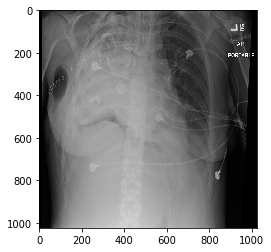

In [8]:
# Showing a dicom image into python:
image_path = 'stage_2_train_images/fffc95b5-605b-4226-80ab-62caec682b22.dcm'
ds = dicom.dcmread(image_path)
im = ds.pixel_array
im = np.stack([im] * 3, axis=2)#convert to three channel
plt.imshow(im,cmap='gray')

plt.show()

In [9]:
# size of dicom sample image
im.shape

(1024, 1024, 3)

# Reading the dataset into python:

In [10]:
# Reading first dataset using pandas:
dataset=pd.read_csv('stage_2_train_labels.csv')

In [11]:
# First look of the csv:
dataset.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


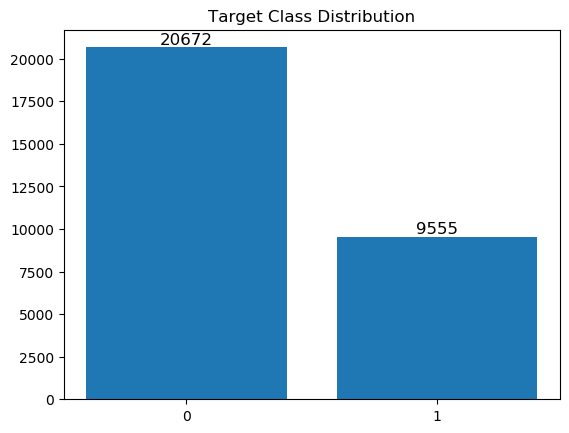

In [12]:
# Distribution of classes:
plt.style.use('default')
label=dataset['Target'].unique()
ht=dataset["Target"].value_counts()
plt.bar(x=label,height=ht)
plt.title("Target Class Distribution")
plt.xticks(ticks=[0,1])
plt.text(0, ht[0]+200, ht[0],fontsize=12,horizontalalignment='center')
plt.text(1, ht[1]+200, ht[1],fontsize=12,horizontalalignment='center')
plt.show()

In [13]:
# Reading the dataset 2 using pandas:
dataset2=pd.read_csv('stage_2_detailed_class_info.csv')
dataset2.head(6)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


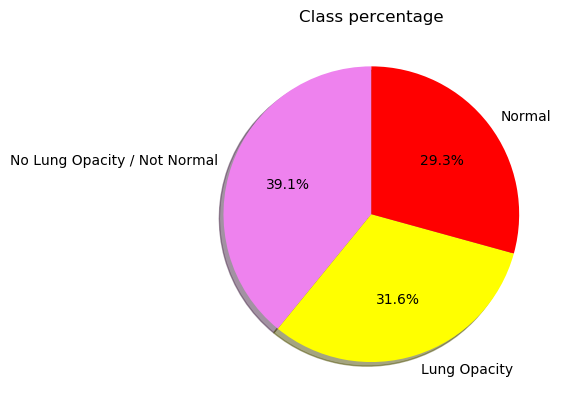

In [14]:
# Basic Eda for Class Distribution:
class_info=dataset2["class"].value_counts()

labels = (np.array(class_info.index))
sizes = (np.array((class_info / class_info.sum())*100))
colors = ['violet', 'yellow','red']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Class percentage")
plt.show()


# Merging two dataset into one dataframe:

In [15]:
#specifying columns names(heres we are using only 2 bounding box coordinates into account)
ColName=['patientid','x1','y1','w1','h1','x2','y2','w2','h2','Target','Class','Gender']
# iterating over patient ID to get unique record(row) with respect to patient ID:
ls_of_ls=[]
for ids in np.unique(dataset['patientId']):
    meta_info = dicom.read_file('D:/DS AI ML/Capstone Project CV/stage_2_train_images/'+ids+'.dcm')
    if len(list(dataset['x'][dataset['patientId']==ids]))>1:
        #print(ids)
        ls=[]
        ls.append(ids)
        ls.append(list(dataset[dataset['patientId']==ids]['x'])[0])
        ls.append(list(dataset[dataset['patientId']==ids]['y'])[0])
        ls.append(list(dataset[dataset['patientId']==ids]['width'])[0])
        ls.append(list(dataset[dataset['patientId']==ids]['height'])[0])
        ls.append(list(dataset[dataset['patientId']==ids]['x'])[1])
        ls.append(list(dataset[dataset['patientId']==ids]['y'])[1])
        ls.append(list(dataset[dataset['patientId']==ids]['width'])[1])
        ls.append(list(dataset[dataset['patientId']==ids]['height'])[1])
        ls.append(list(dataset[dataset['patientId']==ids]['Target'])[1])
        ls.append(list(dataset2[dataset2['patientId']==ids]['class'])[0])
        ls.append(meta_info.PatientSex)
        ls_of_ls.append(ls)
    else:
        ls=[ids,0,0,0,0,0,0,0,0,0]
        ls.append(list(dataset2[dataset2['patientId']==ids]['class'])[0])
        ls.append(meta_info.PatientSex)
        ls_of_ls.append(ls)
# Saving the dataframe into variable:
image_info_df=pd.DataFrame(ls_of_ls,columns=ColName)

In [16]:
# Removing the 3rd class:
image_info_df=image_info_df[image_info_df['Class']!="No Lung Opacity / Not Normal"]

In [17]:
# Checking the merged dataset
image_info_df.head(5)

,patientid,x1,y1,w1,h1,x2,y2,w2,h2,Target,Class,Gender
1,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal,F
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,660.0,375.0,146.0,402.0,1,Lung Opacity,F
3,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,83.0,227.0,296.0,438.0,1,Lung Opacity,M
4,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,552.0,164.0,376.0,676.0,1,Lung Opacity,M
5,0010f549-b242-4e94-87a8-57d79de215fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Normal,M


In [18]:
#shape of the merged dataset:
print("Rows of the merged dataframe: {0} \nColumns of the merged dataframe :{1}".format(image_info_df.shape[0],image_info_df.shape[1]))

Rows of the merged dataframe: 14863 
Columns of the merged dataframe :12


In [19]:
# Now checking the class distribution after merging:
image_info_df.groupby('Target').count()['Class']

Target
0    11465
1     3398
Name: Class, dtype: int64

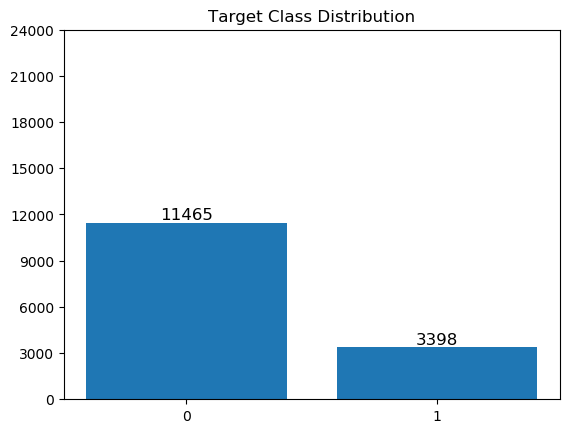

In [20]:
# Distribution of classes on merged dataset:
plt.style.use('default')
label=image_info_df['Target'].unique()
ht=image_info_df["Target"].value_counts()
plt.bar(x=label,height=ht)
plt.title("Target Class Distribution")
plt.xticks(ticks=[0,1])
plt.yticks(np.arange(0,25000,3000))
plt.text(0, ht[0]+200, ht[0],fontsize=12,horizontalalignment='center')
plt.text(1, ht[1]+200, ht[1],fontsize=12,horizontalalignment='center')
plt.show()

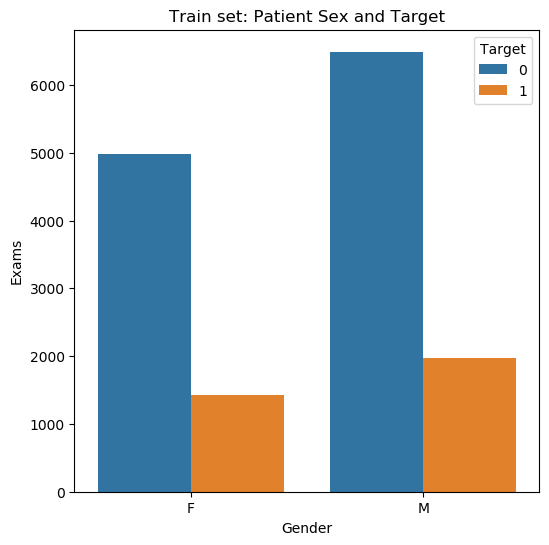

In [21]:
tmp = image_info_df.groupby(['Target', 'Gender'])['patientid'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'Gender']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'Gender', y='Exams', hue='Target',data=df2)
plt.title("Train set: Patient Sex and Target")
plt.show()

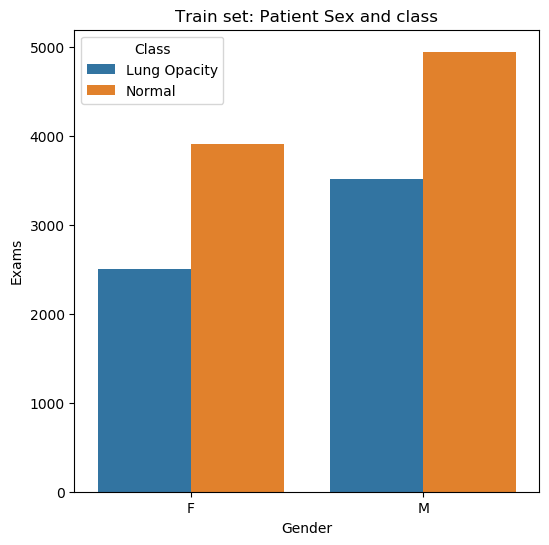

In [22]:
tmp = image_info_df.groupby(['Class', 'Gender'])['patientid'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','Class', 'Gender']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'Gender', y='Exams', hue='Class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()

# Displaying Dicom images with Bounded boxes:

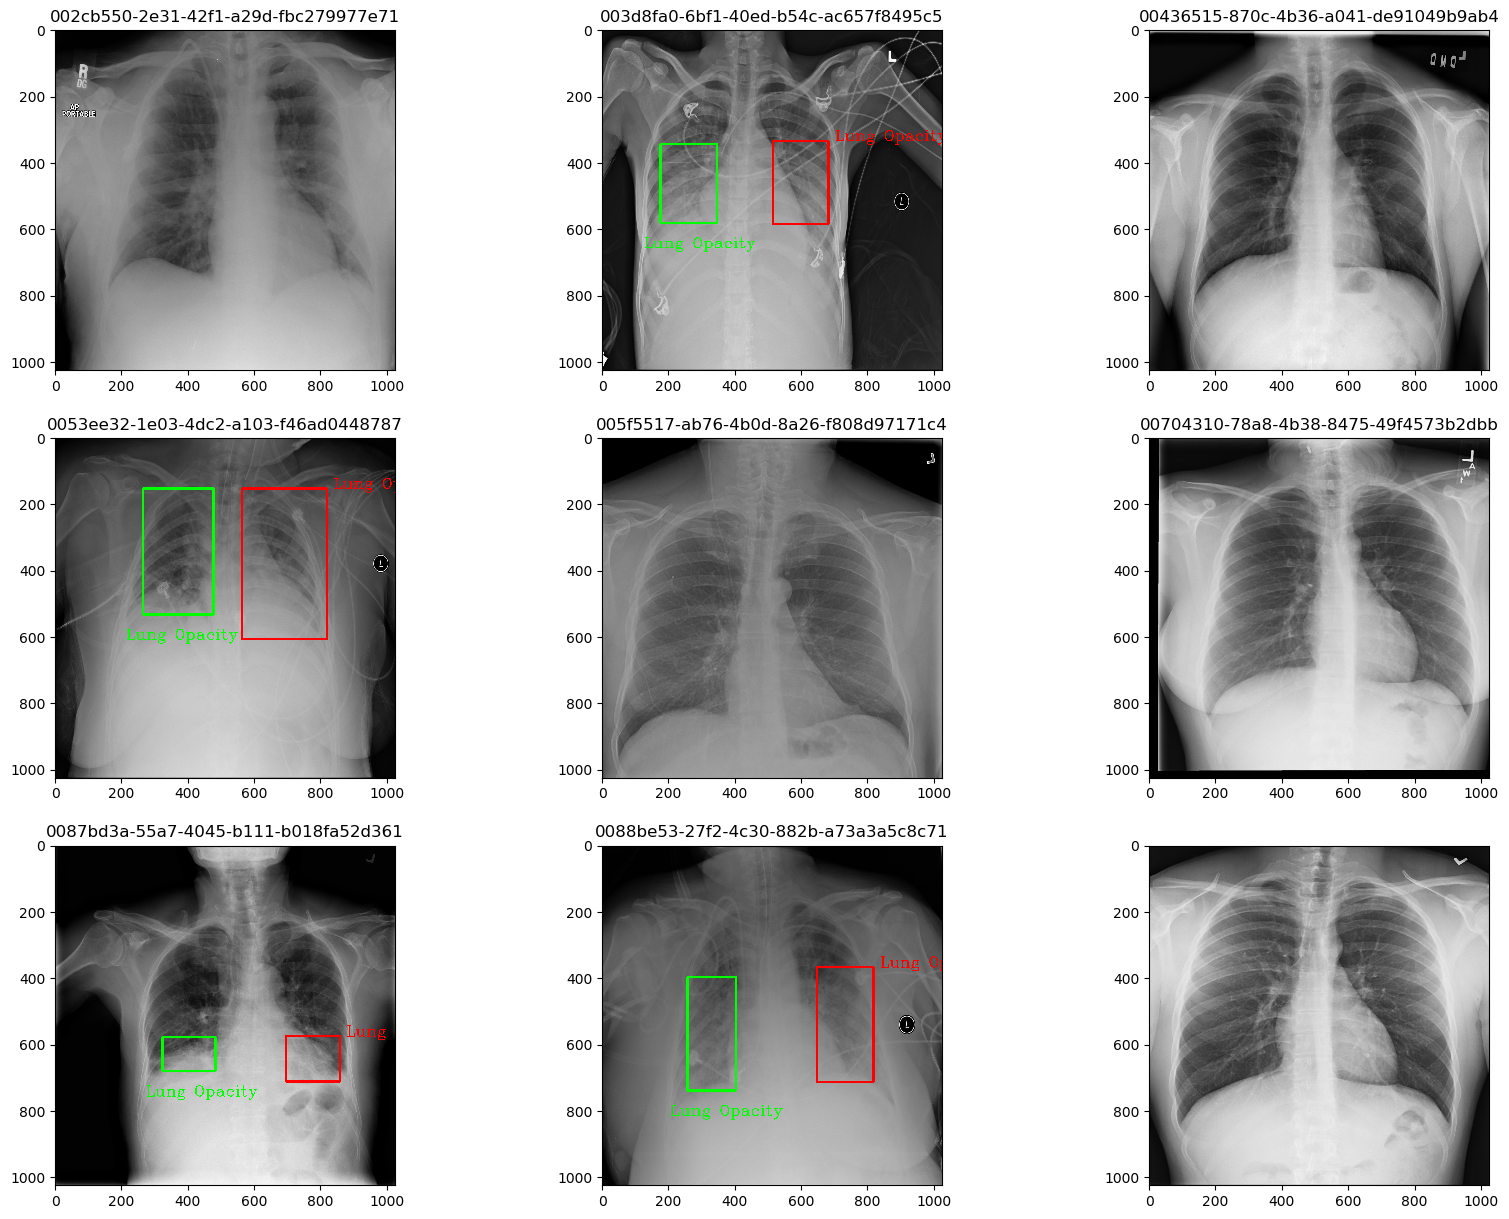

In [23]:

#listing=os.listdir(os.path.join(path,"JPG.stage_2_train_images"))[10:19]
listing=[x+".jpg" for x in image_info_df['patientid'].unique()][10:19]
plt.figure(figsize=(20,15))
i=1
for listing in listing:
    os.chdir(os.path.join(path,"JPG.stage_2_train_images"))
    img_arr=cv2.imread(listing)

    idz=listing.replace('.jpg','')
    plt.title(idz)
    x1=int(image_info_df[image_info_df['patientid']==idz]['x1'])
    y1=int(image_info_df[image_info_df['patientid']==idz]['y1'])
    w1=int(image_info_df[image_info_df['patientid']==idz]['w1'])    
    h1=int(image_info_df[image_info_df['patientid']==idz]['h1'])
    cls=list(image_info_df[image_info_df['patientid']==idz]['Class'])[0]
    if x1>0:   
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        img_arr = cv2.rectangle(img_arr, (x1,y1), (x1+w1,y1+h1), (0,255,0) , 5)
        cv2.putText(img_arr,cls,(x1-50,y1+h1+75),cv2.FONT_HERSHEY_COMPLEX,1.5,(0,255,0),2)
        x2=int(image_info_df[image_info_df['patientid']==idz]['x2'])
        y2=int(image_info_df[image_info_df['patientid']==idz]['y2'])
        w2=int(image_info_df[image_info_df['patientid']==idz]['w2'])    
        h2=int(image_info_df[image_info_df['patientid']==idz]['h2'])
        img_arr = cv2.rectangle(img_arr, (x2,y2), (x2+w2,y2+h2), (255,0,0) , 5) 
        cv2.putText(img_arr,cls,(x2+w2+20,y2),cv2.FONT_HERSHEY_COMPLEX,1.5,(255,0,0),2)
    plt.subplot(3,3,i)
    plt.imshow(img_arr)
    i+=1
    
    

# Creating image resizer as we are not using 1024x1024 image:

In [24]:
#image resize

def image_resizer(path,new_im_w,new_im_h):
    #listing=os.listdir(os.path.join(path,"JPG.stage_2_train_images"))[10:19]
    listing=[x+".jpg" for x in image_info_df['patientid'].unique()][10:19]
    plt.figure(figsize=(20,15))
    i=1
    for listing in listing:
        os.chdir(os.path.join(path,"JPG.stage_2_train_images"))
        img_arr=cv2.imread(listing)
        orig_im_h, orig_im_w, channels = img_arr.shape 
        dsize=(new_im_w,new_im_h)
        img_arr_resize=cv2.resize(img_arr,dsize,cv2.INTER_CUBIC)
        idz=listing.replace('.jpg','')
        idz,x1,y1,w1,h1,x2,y2,w2,h2,target,label=[np.array(image_info_df[image_info_df['patientid']==idz])[0][i] for i in range(11)]
        if x1>0:
            # adjusting the bounding box coordinates based on new image size
            ratio_w=new_im_w/orig_im_w
            ratio_h=new_im_h/orig_im_h
            new_x1=int(x1*ratio_w)
            new_y1=int(y1*ratio_h)
            new_x2=int(x2*ratio_w)
            new_y2=int(y2*ratio_h)
            new_w1=int(w1*ratio_w)
            new_h1=int(h1*ratio_h)
            new_w2=int(w2*ratio_w)
            new_h2=int(h2*ratio_h)  
            img_arr_resize = cv2.rectangle(img_arr_resize, (new_x1,new_y1), (new_x1+new_w1,new_y1+new_h1), (0,255,0) , 2)
            cv2.putText(img_arr_resize,label,(new_x1-5,new_y1+new_h1+32),cv2.FONT_HERSHEY_COMPLEX,0.25,(0,255,0),1)
            img_arr_resize = cv2.rectangle(img_arr_resize, (new_x2,new_y2), (new_x2+new_w2,new_y2+new_h2), (0,255,0) , 2)
            cv2.putText(img_arr_resize,label,(new_x2-5,new_y2+new_h2+32),cv2.FONT_HERSHEY_COMPLEX,0.25,(0,255,0),1)
        plt.subplot(3,3,i)
        plt.imshow(img_arr_resize)
        i+=1
        

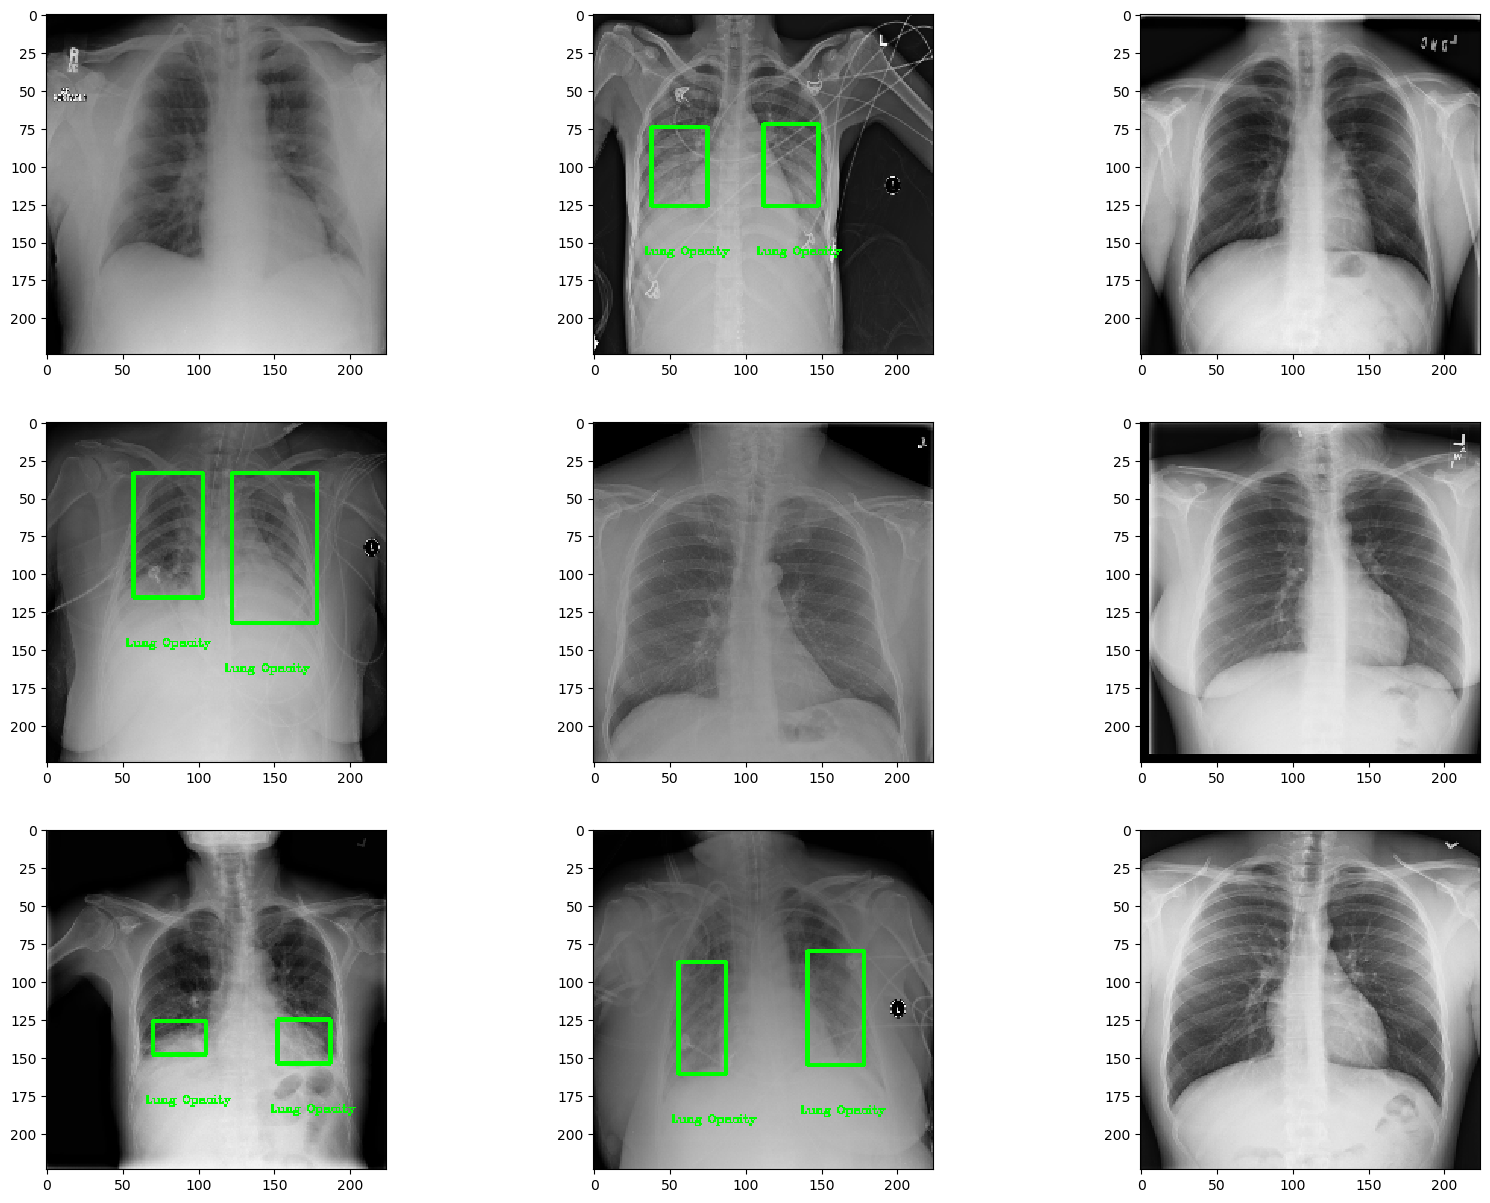

In [25]:
#checking the images examples by using above user defined function:
image_resizer(path,224,224)

# Image Resizer with Xtrain,Mask data generator fuction:

In [26]:
# fuction will return three array X_train,Mask and Target(y_train for classification):
def image_resizer_mask_generator(path,new_im_w,new_im_h):
    #listing=os.listdir(os.path.join(path,"JPG.stage_2_train_images"))
    listing=[x+".jpg" for x in image_info_df['patientid'].unique()]
    
    #initializing the X_train:
    X_train=np.zeros((len(listing),new_im_w,new_im_h,3))
    #initializing the mask:
    mask=np.zeros((len(listing),new_im_w,new_im_h))
    #initializing the target:
    target=np.zeros(len(listing))
    i=1
    for index in range(len(listing)):
        os.chdir(os.path.join(path,"JPG.stage_2_train_images"))
        img_arr=cv2.imread(listing[index])
        orig_im_h, orig_im_w, channels = img_arr.shape 
        dsize=(new_im_w,new_im_h)
        img_arr_resize=cv2.resize(img_arr,dsize,cv2.INTER_CUBIC)
        #feeding into xtrain
        X_train[index]=preprocess_input(np.array(img_arr_resize, dtype=np.float32))
        idz=listing[index].replace('.jpg','')
        idz,x1,y1,w1,h1,x2,y2,w2,h2,tgt,label=[np.array(image_info_df[image_info_df['patientid']==idz])[0][i] for i in range(11)]
        target[index]=tgt
        if x1>0:
            ratio_w=new_im_w/orig_im_w
            ratio_h=new_im_h/orig_im_h
            new_x1=int(x1*ratio_w)
            new_y1=int(y1*ratio_h)
            new_x2=int(x2*ratio_w)
            new_y2=int(y2*ratio_h)
            new_w1=int(w1*ratio_w)
            new_h1=int(h1*ratio_h)
            new_w2=int(w2*ratio_w)
            new_h2=int(h2*ratio_h)  
            mask[index][new_y1:new_y1+new_h1, new_x1:new_x1+new_w1] = 1
            mask[index][new_y2:new_y2+new_h2, new_x2:new_x2+new_w2] = 1
        i+=1
    return X_train,mask,target
        
    

In [27]:
# Getting the data generation with image size 128x128 reason for that we will be using Mobilenet Transfer Learing model:
start = timeit.default_timer()
(X_train,mask,target)=image_resizer_mask_generator(path,128,128)
stop = timeit.default_timer()
#os.chdir(r'D:\DS AI ML\Capstone Project CV\NPY')
#np.save('Xtrain.npy',X_train)
#np.save('mask.npy',mask)
#np.save('target.npy',target)
print('Time: ', stop - start)  

Time:  399.28768170000006


# Imbalanced Data Rectification:


"above we saw that class distribution is *not* balanced so we need to solve that problem as model will give biased prediction for majority class label"


In [28]:

#split the target class 0
start = timeit.default_timer()
target_0=target[target==0]
X_train_0=X_train[target==0]
mask_0=mask[target==0]
len(target_0)
#23K

#split the target class 1
target_1=target[target==1]
X_train_1=X_train[target==1]
mask_1=mask[target==1]
len(target_1)
#3.4K


# balance the clases using random function
target_balanced=np.zeros((2*len(target_1)))
X_train_balanced=np.zeros((2*len(target_1),X_train_1.shape[1],X_train_1.shape[2],X_train_1.shape[3]))
mask_balanced=np.zeros((2*len(target_1),mask_1.shape[1],mask_1.shape[2]))
index=0
for i in (np.random.choice(len(target_0),len(target_1),replace=False)):
    #print(i)
    X_train_balanced[index]=X_train_0[i]
    mask_balanced[index]=mask_0[i]
    target_balanced[index]=target_0[i]
    index+=1
j=0
for ix in np.arange(len(target_1),X_train_balanced.shape[0],1):
    #print(index)
    X_train_balanced[ix]=X_train_1[j]
    mask_balanced[ix]=mask_1[j]
    target_balanced[ix]=target_1[j]
    j+=1
stop = timeit.default_timer()
print('Time: ', stop - start)  

Time:  216.8877298


In [29]:
# one encoding target variable for CNN:
from tensorflow.keras.utils import to_categorical
target_encoded=to_categorical(target_balanced,num_classes=2)

In [30]:
# Shuffling the whole data:
from sklearn.utils import shuffle
X_train_balanced,mask_balanced,target_encoded=shuffle(X_train_balanced,mask_balanced,target_encoded)

1.0


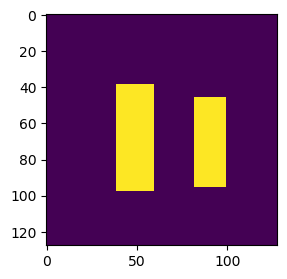

In [38]:
# Checking the masks:
plt.figure(figsize=(3,3))
plt.imshow(mask_1[0])
print(target_1[0])

# Splitting the data into training set and evaluation set:

In [39]:
#taking first 5000 images array for training and rest for evaluation:
Training_X=X_train_balanced[0:5000,:,:,:]
Eval_X=X_train_balanced[5000:,:,:,:]
Training_mask=mask_balanced[0:5000,:,:]
Eval_mask=mask_balanced[5000:,:,:]
Training_y=target_encoded[0:5000]
Eval_y=target_encoded[5000:]

In [42]:
#for computation restrictions we are training UNET only on images which has targer as 1(Lung Opacity)
# taking first 10 records for evaluation and rest for training
eval_X_1=X_train_1[0:10]
eval_mask_1=mask_1[0:10]
Training_X_1=X_train_1[10:]
Training_mask_1=mask_1[10:]

In [44]:
#saved all arrays as .npy file into our hdd:
os.chdir(r'D:\DS AI ML\Capstone Project CV\NPY')
np.save('Training_X.npy',Training_X)
np.save('Training_y.npy',Training_y)
np.save('Training_mask.npy',Training_mask)
np.save('Eval_X.npy',Eval_X)
np.save('Eval_y.npy',Eval_y)
np.save('Eval_mask.npy',Eval_mask)
np.save('X_train_1.npy',X_train_1)
np.save('mask_1.npy',mask_1)
np.save('Training_X_1.npy',Training_X_1)
np.save('Training_mask_1.npy',Training_mask_1)
np.save('eval_X_1.npy',eval_X_1)
np.save('eval_mask_1.npy',eval_mask_1)

In [4]:
#to load NPy files:

os.chdir(r'D:\DS AI ML\Capstone Project CV\NPY')
Training_X=np.load('Training_X.npy')
Training_y=np.load('Training_y.npy')
Training_mask=np.load('Training_mask.npy')
X_train_1=np.load('X_train_1.npy')
mask_1=np.load('mask_1.npy')
Eval_X=np.load('Eval_X.npy')
Eval_y=np.load('Eval_y.npy')
Eval_mask=np.load('Eval_mask.npy')
Training_X_1=np.load('Training_X_1.npy')
Training_mask_1=np.load('Training_mask_1.npy')
eval_X_1=np.load('eval_X_1.npy')
eval_mask_1=np.load('eval_mask_1.npy')

# Model Building(Base Model):

In [5]:
#Basic Model Architecture:
import tensorflow
tensorflow.keras.backend.clear_session() 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
tf.keras.backend.clear_session()
#Build a model
model = Sequential()

# Add the first convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),padding='same', activation='relu', input_shape=(Training_X.shape[1], Training_X.shape[2], 3))) 
# Add the first pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second convolution layer
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
# Add the second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
#Add drop out layer 
model.add(Dropout(0.2))

# Add the third convolution layer
model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
# Add the third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
#Add drop out layer
model.add(Dropout(0.2))

# Flatten the matrix into vector
model.add(Flatten())
model.add(Dropout(0.2))

# Add a dense (or fully connected) layer
model.add(Dense(32, activation='relu'))

# Add output layer
model.add(Dense(2, activation='softmax'))

In [6]:
#Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0

# Transfer Learning model with two branches one for classification other for bounding box prediction using UNET:

In [7]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape,Input,Dropout,Dense,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

tf.keras.backend.clear_session()
def create_model(trainable=True):
    with tf.device('/CPU:0'):

        #model = MobileNet(weights='imagenet',include_top=False,input_shape=(Training_X.shape[1], Training_X.shape[2], 3),alpha=1.0)
        model = MobileNet(weights='imagenet',include_top=False,input_shape=(128,128,3),alpha=1.0)
        for layer in model.layers:
            layer.trainable=trainable
            #print(layer,layer.trainable)
        #considering skip connections:
        block0=model.input
        block1=model.get_layer("conv_pw_1_relu").output #112x112
        block2=model.get_layer("conv_pw_3_relu").output #56x56
        block3=model.get_layer("conv_pw_5_relu").output # #28x28
        block4=model.get_layer("conv_pw_11_relu").output #14x14
        block5=model.get_layer("conv_pw_13_relu").output #7x7

        #classification layers:
        y=tf.keras.layers.MaxPool2D(pool_size=(2,2))(block5)
        y=tf.keras.layers.Flatten()(y)
        y=BatchNormalization()(y)
        y=Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(y)
        y=Dropout(0.5)(y)
        y=Dense(64,activation='relu')(y)
        y=Dropout(0.5)(y)
        y=Dense(2,activation='softmax')(y)


        #Decoder:
        x=Concatenate()([UpSampling2D()(block5),block4])
        x=Concatenate()([UpSampling2D()(x),block3])
        x=Concatenate()([UpSampling2D()(x),block2])
        x=Concatenate()([UpSampling2D()(x),block1])
        x=Concatenate()([UpSampling2D()(x),block0])
        #we can add more layers for better results but it reduces the processing speed
        #x=Conv2D(64,kernel_size=3,activation='relu',padding='same')(x)
        #x=BatchNormalization()(x)
        #x=Dropout(0.5)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x=Conv2D(16,kernel_size=3,activation='relu',padding='same')(x)
        x=Dropout(0.3)(x)
        x=Conv2D(1,kernel_size=1,activation="sigmoid")(x)
        x=Reshape(target_shape=(128,128))(x)
        return Model(inputs=model.input, outputs=x), Model(inputs=model.input,outputs=y)

In [8]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
(model1,model2) = create_model(trainable=False)

# Print summary
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 32)   864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 32)   128         conv1[0][0]                      
______________________________________________________________________________________________


for layer in model2.layers:
    print(layer,layer.trainable)

In [9]:
# Dice coefficient for Unet:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [10]:
# creating the custom loss function for unet:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import tensorflow
# Compiling the models using adam optimizer:
with tf.device('/CPU:0'):
    optimizer1 = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    optimizer=Adam(0.00001)
    #optimizer1=Adam(0.0001)
    #optimizer=SGD(lr=0.01, momentum=0.9)
    #model1.compile(loss=loss, optimizer=optimizer1, metrics=[dice_coefficient],options=run_opts)
    model1.compile(loss=loss, optimizer=optimizer1, metrics=[dice_coefficient])
    model2.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# applying callbacks for better model and for saving the time:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

# Fit the Model(basic CNN)

In [38]:
import tensorflow as tf
#tf.keras.backend.clear_session()
#os.mkdir(os.path.join(path,'weights')
os.chdir(os.path.join(path,'weights','classifier'))
history=model.fit(Training_X,Training_y,epochs=100,callbacks=[checkpoint, reduce_lr, stop],batch_size=1,validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
3997/4000 [============================>.] - ETA: 0s - loss: 0.6316 - accuracy: 0.6632
Epoch 00001: loss improved from inf to 0.63152, saving model to model-0.63.h5
4000/4000 [==============================] - 41s 10ms/sample - loss: 0.6315 - accuracy: 0.6633 - val_loss: 0.5754 - val_accuracy: 0.7570
Epoch 2/100
3991/4000 [============================>.] - ETA: 0s - loss: 0.5203 - accuracy: 0.7615
Epoch 00002: loss improved from 0.63152 to 0.52051, saving model to model-0.52.h5
4000/4000 [==============================] - 29s 7ms/sample - loss: 0.5205 - accuracy: 0.7610 - val_loss: 0.5035 - val_accuracy: 0.7830
Epoch 3/100
3994/4000 [============================>.] - ETA: 0s - loss: 0.4794 - accuracy: 0.7809
Epoch 00003: loss improved from 0.52051 to 0.47918, saving model to model-0.48.h5
4000/4000 [==============================] - 29s 7ms/sample - loss: 0.4792 - accuracy: 0.7812 - val_loss: 0.4754 - val_accuracy: 0.8040
Epoc

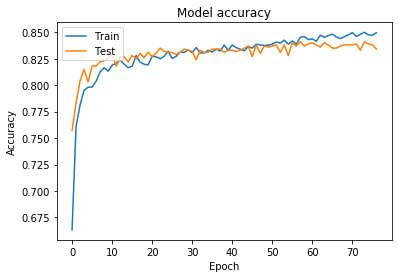

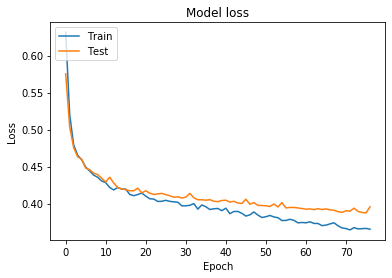

In [39]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [52]:
# Model Evaluation:
results=model.evaluate(Eval_X,Eval_y,verbose=0)
print('eval loss : {}, eval acc : {}'.format(results[0],results[1]))

eval loss : 0.4191395445231074, eval acc : 0.814031183719635


In [53]:
from sklearn.metrics import classification_report
prediction=model.predict(Eval_X)
y_pred=np.argmax(prediction,axis=1)
y_actual=np.argmax(Eval_y,axis=1)
print(classification_report(y_actual,y_pred))
clf_report=classification_report(y_actual,y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       881
           1       0.80      0.85      0.82       915

    accuracy                           0.81      1796
   macro avg       0.82      0.81      0.81      1796
weighted avg       0.82      0.81      0.81      1796



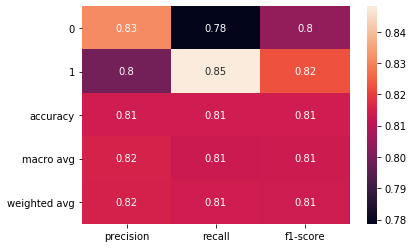

In [54]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:].T,annot=True)

# Fit the Transfer Learning Model:

In [123]:
import tensorflow as tf
#tf.keras.backend.clear_session()
#os.mkdir(os.path.join(path,'weights')
os.chdir(os.path.join(path,'weights','classifier_TL'))
with tf.device('/GPU:0'):
    history2=model2.fit(Training_X,Training_y,epochs=100,batch_size=20,validation_split=0.2,callbacks=[checkpoint, reduce_lr, stop])

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
3960/4000 [============================>.] - ETA: 0s - loss: 12.8846 - accuracy: 0.6141
Epoch 00001: loss improved from inf to 12.88947, saving model to model-12.89.h5
4000/4000 [==============================] - 18s 5ms/sample - loss: 12.8895 - accuracy: 0.6140 - val_loss: 12.3749 - val_accuracy: 0.7710
Epoch 2/100
3980/4000 [============================>.] - ETA: 0s - loss: 12.4840 - accuracy: 0.7284
Epoch 00002: loss improved from 12.88947 to 12.48336, saving model to model-12.48.h5
4000/4000 [==============================] - 12s 3ms/sample - loss: 12.4834 - accuracy: 0.7285 - val_loss: 12.1539 - val_accuracy: 0.7850
Epoch 3/100
3980/4000 [============================>.] - ETA: 0s - loss: 12.3068 - accuracy: 0.7515
Epoch 00003: loss improved from 12.48336 to 12.30504, saving model to model-12.31.h5
4000/4000 [==============================] - 12s 3ms/sample - loss: 12.3050 - accuracy: 0.7523 - val_loss: 12.0395 - val_accur

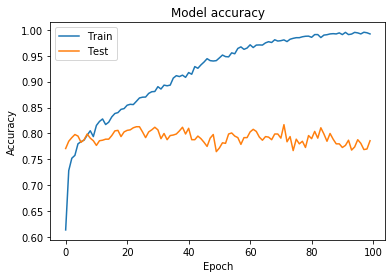

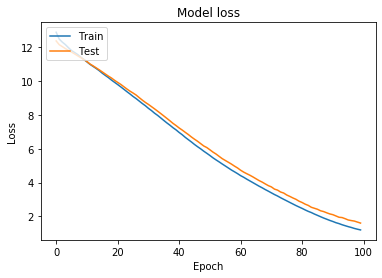

In [124]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [61]:
# Model Evaluation:
results=model2.evaluate(Eval_X,Eval_y,verbose=0)
print('eval loss : {}, eval acc : {}'.format(results[0],results[1]))

eval loss : 9.428104128763245, eval acc : 0.7995545864105225


In [59]:
from sklearn.metrics import classification_report
prediction=model2.predict(Eval_X)
y_pred=np.argmax(prediction,axis=1)
y_actual=np.argmax(Eval_y,axis=1)
print(classification_report(y_actual,y_pred))
clf_report=classification_report(y_actual,y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       881
           1       0.87      0.71      0.78       915

    accuracy                           0.80      1796
   macro avg       0.81      0.80      0.80      1796
weighted avg       0.81      0.80      0.80      1796



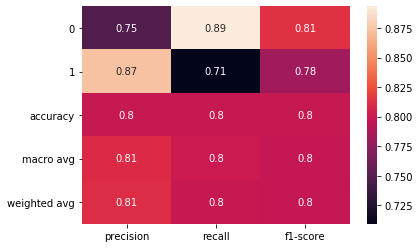

In [60]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:].T,annot=True)

# Fit the UNET Model:

In [19]:
import tensorflow as tf
#os.mkdir(os.path.join(path,'weights')
with tf.device('/GPU:0'):
    BATCHSIZE=2
    os.chdir(os.path.join(path,'weights'))
    history3=model1.fit(Training_X_1,Training_mask_1,epochs=50,callbacks=[checkpoint, reduce_lr, stop],batch_size=BATCHSIZE,validation_split=0.35,workers=4)

Train on 2202 samples, validate on 1186 samples
Epoch 1/50
2200/2202 [============================>.] - ETA: 0s - loss: 1.0279 - dice_coefficient: 0.5259
Epoch 00001: loss improved from inf to 1.02779, saving model to model-1.03.h5
2202/2202 [==============================] - 164s 74ms/sample - loss: 1.0278 - dice_coefficient: 0.5259 - val_loss: 0.8996 - val_dice_coefficient: 0.5491
Epoch 2/50
2200/2202 [============================>.] - ETA: 0s - loss: 0.9283 - dice_coefficient: 0.5610
Epoch 00002: loss improved from 1.02779 to 0.92821, saving model to model-0.93.h5
2202/2202 [==============================] - 147s 67ms/sample - loss: 0.9282 - dice_coefficient: 0.5610 - val_loss: 0.9919 - val_dice_coefficient: 0.5572
Epoch 3/50
2200/2202 [============================>.] - ETA: 0s - loss: 0.8992 - dice_coefficient: 0.5706 ETA: 1s - loss: 0
Epoch 00003: loss improved from 0.92821 to 0.89919, saving model to model-0.90.h5
2202/2202 [==============================] - 146s 66ms/sample - lo

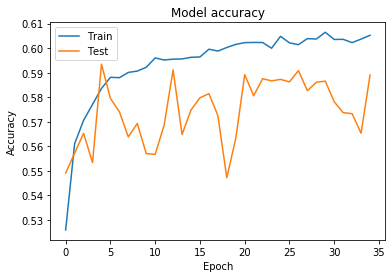

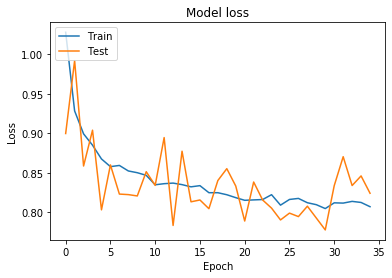

In [20]:
# Plot training & validation accuracy values
plt.plot(history3.history['dice_coefficient'])
plt.plot(history3.history['val_dice_coefficient'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
#load the model:
os.chdir(r'D:\DS AI ML\Capstone Project CV\weights')
model1.load_weights('model-0.89.h5')

In [14]:
# Model Evaluation:
with tf.device('/CPU:0'):
    results=model1.evaluate(eval_X_1,eval_mask_1,verbose=-1)
    print('eval loss : {}, eval acc : {}'.format(results[0],results[1]))

eval loss : 0.7979829907417297, eval acc : 0.5841150283813477


In [15]:
#load the classification model:
os.chdir(r'D:\DS AI ML\Capstone Project CV\weights\classifier_TL')
model2.load_weights('model-9.24.h5')

In [16]:
#load the classification model:
os.chdir(r'D:\DS AI ML\Capstone Project CV\weights\classifier')
model.load_weights('model-0.39.h5')

In [17]:
# Test Data Gen:
os.chdir(r'D:\DS AI ML\Capstone Project CV\JPG.stage_2_test_images')
files=os.listdir()

In [18]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

HEIGHT_CELLS = 128
WIDTH_CELLS = 128

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS
Ratio=1024/128

THRESHOLD = .5
EPSILON = 0.02

# Prediction on unseen data:

In [45]:
import cv2
def test_prediction(path,new_im_w,new_im_h):
    cords=[];list_cords=[]
    ii=0
    colz=['X1_cord','Y1_cord','X2_cord','Y2_cord','area']
    sub_df=pd.DataFrame(columns=['patientid','PredictionString'])
    os.chdir(path)
    listing=os.listdir()[13:20]
    for ls in listing:
        print(ls)
        patient_uid=ls.split('.')[0]
        img_arr=cv2.imread(ls)
        img_arr_copy=np.copy(img_arr)
        orig_im_h, orig_im_w, channels = img_arr.shape 
        dsize=(new_im_w,new_im_h)
        img_arr_resize=cv2.resize(img_arr_copy,dsize,cv2.INTER_CUBIC)
        pp_img_arr=preprocess_input(np.array(img_arr_resize, dtype=np.float32))
        pp_img_arr_=np.expand_dims(pp_img_arr,axis=0)
        #print(pp_img_arr.shape)
        predict_vec=model2.predict(pp_img_arr_)
        class_predicted=np.argmax(predict_vec)
        #print(class_predicted)
        if(class_predicted==1):
            
            pred_mask=model1.predict(pp_img_arr_)
            output = np.zeros(pp_img_arr.shape[:2], dtype=np.uint8)
            for i in range(pred_mask[0].shape[1]):
                for j in range(pred_mask[0].shape[0]):
                    if pred_mask[0][i][j] > THRESHOLD:
                        
                        x = int(CELL_WIDTH * j * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y = int(CELL_HEIGHT * i * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        x2 = int(CELL_WIDTH * (j + 1) * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y2 = int(CELL_HEIGHT * (i + 1) * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        #cv2.rectangle(sample_image, (x, y), (x2, y2), (0, 255, 0), 1)

                        output[y:y2,x:x2] = 1
            #print(output.shape)
            #plt.imshow(output)
            #creating bounding boxes
            contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            #cv2.drawContours(img_arr_resize, contours, -1, (0,255,0), 3)
            #plt.imshow(img_arr_resize)
            #print(contours)
            
            for cnt in contours:
                approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
                x, y, w, h = cv2.boundingRect(approx)
                #print('box:',x,y,x+w,y+h)
                cords.append(x)
                cords.append(y)
                cords.append(x+w)
                cords.append(y+h)
                cords.append(w*h)
                list_cords.append(list(cords))
                #print(list_cords,"-------")
                cords=[]
                #cv2.rectangle(img_arr_resize, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            #box_cord_f.append((ls,np.array(box_cord),area))
            df=pd.DataFrame(list_cords,columns=colz)
            df.sort_values(by='area',inplace=True,ascending=False)
            list_cords=[]
            df=df[:2]
            x11,y11,x12,y12,_=np.array(df[:1])[0]
            x11_org,y11_org,x12_org,y12_org,_=np.array(Ratio*np.array(df[:1])[0],dtype='int64')
            print("BBOX1----",x11_org,y11_org,x12_org,y12_org)
            string1=' '.join(str(x) for x in (round(predict_vec[0][1],2),x11_org,y11_org,x12_org,y12_org))
            img_arr_resize=cv2.rectangle(img_arr_resize, (x11,y11), (x12,y12), (0, 255, 230), 1)
            img_arr=cv2.rectangle(img_arr, (int(x11_org),int(y11_org)), (int(x12_org),int(y12_org)), (0, 255, 230), 5)

            x21,y21,x22,y22,_=np.array(df[1:])[0]
            x21_org,y21_org,x22_org,y22_org,_=Ratio*np.array(df[1:])[0]
            print("BBOX2----",x21_org,y21_org,x22_org,y22_org)
            string2=' '.join(str(x) for x in (round(predict_vec[0][1],2),x21_org,y21_org,x22_org,y22_org))
            sub_1=pd.DataFrame([[patient_uid, string1], [patient_uid, string2]],columns=['patientid','PredictionString'])
            #sub_3=pd.DataFrame([['dffdfdfdfd', '1 2 3 4'], ['dffdffd', '17 27 37 47']],columns=['patientid','PredictionString'])
            #sub_df.append(sub_1)
            sub_df=pd.concat([sub_df, sub_1],ignore_index=True)
            img_arr_resize=cv2.rectangle(img_arr_resize, (x21,y21), (x22,y22), (0, 255, 230), 1)
            img_arr=cv2.rectangle(img_arr, (int(x21_org),int(y21_org)), (int(x22_org),int(y22_org)), (0, 255, 230), 5)
            plt.figure(figsize=(18,12))
            plt.subplot(221)
            plt.title('Patient ID:'+ls.split('.')[0]+' Resolution:128x128')
            plt.imshow(img_arr_resize)
            plt.subplot(222)
            plt.title('Patient ID:'+ls.split('.')[0]+' Resolution:1024x1024')
            plt.imshow(img_arr)
            
        
        else:
            string2=' '.join(str(x) for x in (round(predict_vec[0][1],2),0,0,0,0))
            sub_2=pd.DataFrame([[patient_uid,string2]],columns=['patientid','PredictionString'])
            sub_df=pd.concat([sub_df,sub_2],ignore_index=True)
    return sub_df
        

00330f7f-d114-4eb2-9c6e-558eeb3084a1.jpg
BBOX1---- 448 248 776 888
BBOX2---- 128.0 256.0 392.0 768.0
00342ae8-ff81-4229-adf6-6a2ab711707b.jpg
003d17f0-bd8a-485c-bc8b-daec33f53efa.jpg
BBOX1---- 552 264 792 888
BBOX2---- 232.0 248.0 384.0 584.0
003dba79-1b1d-4713-add8-d72c54074f8a.jpg
003ec9e3-512e-4f6e-923d-daa9f9f3db9a.jpg
003fbda2-ba55-4714-a03a-83f15bec19e4.jpg
BBOX1---- 584 256 888 736
BBOX2---- 256.0 256.0 512.0 760.0
0041fc67-793c-4129-a952-ea3fb821b445.jpg


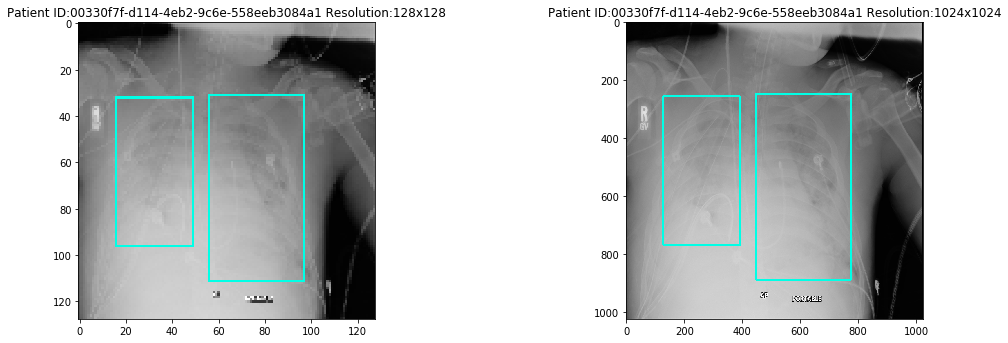

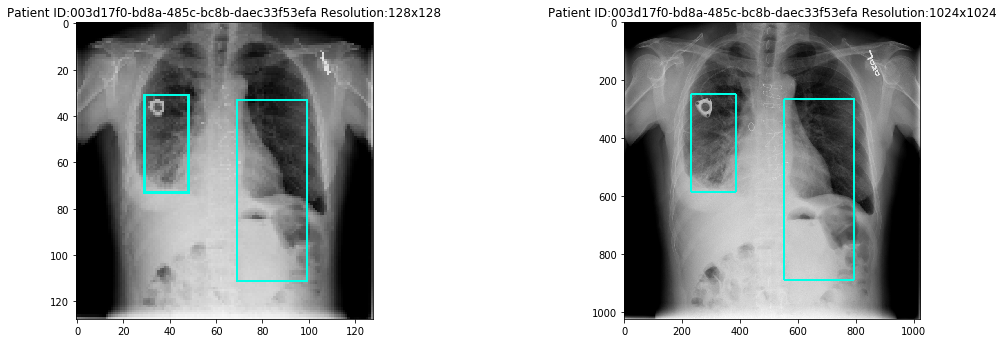

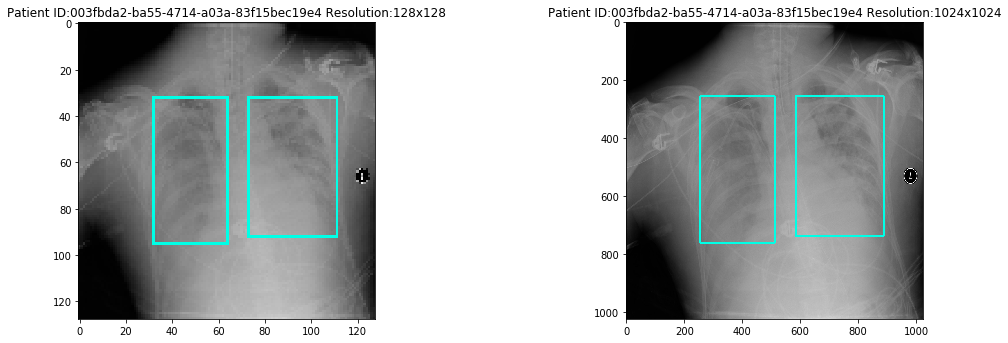

In [46]:
dgen=test_prediction(r'D:\DS AI ML\Capstone Project CV\JPG.stage_2_test_images',128,128)

In [47]:
dgen.head(4)

,patientid,PredictionString
0,00330f7f-d114-4eb2-9c6e-558eeb3084a1,0.8 448 248 776 888
1,00330f7f-d114-4eb2-9c6e-558eeb3084a1,0.8 128.0 256.0 392.0 768.0
2,00342ae8-ff81-4229-adf6-6a2ab711707b,0.16 0 0 0 0
3,003d17f0-bd8a-485c-bc8b-daec33f53efa,0.64 552 264 792 888


In [48]:
def Final_Submission(path,new_im_w,new_im_h):
    cords=[];list_cords=[]
    colz=['X1_cord','Y1_cord','X2_cord','Y2_cord','area']
    sub_df=pd.DataFrame(columns=['patientid','PredictionString'])
    os.chdir(path)
    listing=os.listdir()
    for ls in listing:
        patient_uid=ls.split('.')[0]
        img_arr=cv2.imread(ls)
        img_arr_copy=np.copy(img_arr)
        orig_im_h, orig_im_w, channels = img_arr.shape 
        dsize=(new_im_w,new_im_h)
        img_arr_resize=cv2.resize(img_arr_copy,dsize,cv2.INTER_CUBIC)
        pp_img_arr=preprocess_input(np.array(img_arr_resize, dtype=np.float32))
        pp_img_arr_=np.expand_dims(pp_img_arr,axis=0)
        predict_vec=model2.predict(pp_img_arr_)
        class_predicted=np.argmax(predict_vec)
        if(class_predicted==1):
            
            pred_mask=model1.predict(pp_img_arr_)
            output = np.zeros(pp_img_arr.shape[:2], dtype=np.uint8)
            for i in range(pred_mask[0].shape[1]):
                for j in range(pred_mask[0].shape[0]):
                    if pred_mask[0][i][j] > THRESHOLD:
                        
                        x = int(CELL_WIDTH * j * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y = int(CELL_HEIGHT * i * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        x2 = int(CELL_WIDTH * (j + 1) * pp_img_arr.shape[1] / IMAGE_WIDTH)
                        y2 = int(CELL_HEIGHT * (i + 1) * pp_img_arr.shape[0] / IMAGE_HEIGHT)
                        output[y:y2,x:x2] = 1
            contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
                x, y, w, h = cv2.boundingRect(approx)
                cords.append(x)
                cords.append(y)
                cords.append(x+w)
                cords.append(y+h)
                cords.append(w*h)
                list_cords.append(list(cords))
                cords=[]

            df=pd.DataFrame(list_cords,columns=colz)
            df.sort_values(by='area',inplace=True,ascending=False)
            list_cords=[]
            df=df[:2]
            x11,y11,x12,y12,_=np.array(df[:1])[0]
            x11_org,y11_org,x12_org,y12_org,_=np.array(Ratio*np.array(df[:1])[0],dtype='int64')
            string1=' '.join(str(x) for x in (round(predict_vec[0][1],2),x11_org,y11_org,x12_org,y12_org))
            img_arr_resize=cv2.rectangle(img_arr_resize, (x11,y11), (x12,y12), (0, 255, 230), 1)
            img_arr=cv2.rectangle(img_arr, (int(x11_org),int(y11_org)), (int(x12_org),int(y12_org)), (0, 255, 230), 5)
            x21,y21,x22,y22,_=np.array(df[1:])[0]
            x21_org,y21_org,x22_org,y22_org,_=Ratio*np.array(df[1:])[0]
            string2=' '.join(str(x) for x in (round(predict_vec[0][1],2),x21_org,y21_org,x22_org,y22_org))
            sub_1=pd.DataFrame([[patient_uid, string1], [patient_uid, string2]],columns=['patientid','PredictionString'])
            sub_df=pd.concat([sub_df, sub_1],ignore_index=True)

        else:
            string2=' '.join(str(x) for x in (round(predict_vec[0][1],2),0,0,0,0))
            sub_2=pd.DataFrame([[patient_uid,string2]],columns=['patientid','PredictionString'])
            sub_df=pd.concat([sub_df,sub_2],ignore_index=True)
    return sub_df

In [49]:
Final_Submission_df=Final_Submission(r'D:\DS AI ML\Capstone Project CV\JPG.stage_2_test_images',128,128)

In [50]:
Final_Submission_df.to_csv(r'D:\DS AI ML\Capstone Project CV\Final Submission\Final_Submission.csv',index=False)